In [1]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from shapely import geometry
from utils import *
tqdm.pandas()

plt.rcParams["figure.figsize"] = [12,6]

C:\Users\paulo\anaconda3\envs\faces\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
dataset360 = pd.read_pickle('../dataframes/dataset360_detections.pkl')
dataset360.head(2)

,image_path,metadata,fold,phi,theta,r_h,faces,circular_perimeter_faces,detectionsViewD_3,detectionsViewD_4,detectionsViewD_5,detectionsViewD_6,detectionsViewD_7,detectionsViewD_8,detectionsViewD_9,detectionsViewD_10,detections_sphere_mtcnn,detections_mtcnn
0,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01,35,-123,-1,"[[(1056, 367), (1083, 368), (1110, 366), (1053...","[[(1056, 367), (1083, 368), (1110, 366), (1114...","[[(1054, 375), (1081, 375), (1108, 374), (1108...","[[(1059, 375), (1085, 377), (1112, 377), (1111...","[[(1056, 373), (1083, 376), (1112, 378), (1111...","[[(1054, 377), (1080, 377), (1106, 376), (1110...","[[(1043, 380), (1070, 378), (1095, 376), (1106...","[[(1059, 375), (1085, 377), (1112, 377), (1111...","[[(1048, 381), (1072, 379), (1093, 376), (1105...","[[(1050, 380), (1076, 379), (1101, 376), (1108...",[],"[[(1054, 377), (1111, 377), (1111, 450), (1054..."
1,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,../data/dataset_360/FDDB-fold-01\2002_07_19_bi...,FDDB-fold-01,85,-142,-1,"[[(1118, 537), (1174, 537), (1225, 530), (1100...","[[(1118, 537), (1174, 537), (1225, 530), (1269...","[[(1078, 552), (1143, 547), (1195, 535), (1245...","[[(1112, 546), (1162, 544), (1209, 538), (1249...","[[(1122, 544), (1174, 544), (1223, 539), (1260...","[[(1132, 540), (1189, 542), (1243, 537), (1275...","[[(1137, 545), (1191, 547), (1246, 544), (1276...","[[(1130, 554), (1195, 559), (1259, 555), (12, ...","[[(1099, 566), (1173, 566), (1241, 558), (3, 5...","[[(1143, 541), (1198, 546), (1256, 545), (1, 5...",[],[]


## mAP

In [3]:
def compute_metrics(df, gt_column, pred_column, threshold = 0.5):
    total_faces = df.circular_perimeter_faces.apply(len).sum()

    tps = []
    fps = []

    tp = 0
    fp = 0
    for index , row in df.iterrows(): 
        ground_truths = row['circular_perimeter_faces']
        gt_polys = [geometry.Polygon(adjust_bounds(gt)).convex_hull for gt in ground_truths]

        tests = row[pred_column]   
        for test in tests:               
            ious = []

            for gt_poly in gt_polys:            
                gt_test = geometry.Polygon(adjust_bounds(test)).convex_hull

                iou = gt_poly.intersection(gt_test).area/gt_poly.union(gt_test).area
                ious.append(iou)

            if len(gt_polys) > 0:
                max_iou = np.argmax(ious)

                if ious[max_iou] > threshold:#true positive
                    tp+=1

                    gt_polys.pop(max_iou)

                else:
                    fp += 1
            else: 
                fp += 1

            #print(f'tp: {tp}, fp: {fp}')
            tps.append(tp)
            fps.append(fp)

    tps = np.array(tps)
    fps = np.array(fps)
    
    precision = tps/(tps+fps)
    recall = tps/total_faces

    eval_df = pd.DataFrame({'precision':precision, 'recall':recall})
    
    prec_at_rec = []
    
    ##map
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            x = eval_df[eval_df['recall'] >= recall_level]['precision']
            prec = max(x)
        except:
            prec = 0.0
        prec_at_rec.append(prec)
    avg_prec = np.mean(prec_at_rec)

    #print('11 point precision is ', prec_at_rec)
    #print(f'mAP.{threshold*100} is ', avg_prec)

    return avg_prec, precision, recall, prec_at_rec, tps, fps

In [4]:
total_images_faces = lambda d: f'Faces: {d.circular_perimeter_faces.apply(len).sum()} Images:{len(d.circular_perimeter_faces)}'

## Evaluate Dataset

In [5]:
def evaluate_dataset(dataset, threshold = 0.50):
    d_column_prefix = 'detectionsViewD_'
    d_numbers = [int(c.split('_')[-1]) for c in dataset.columns[::-1] if c.startswith(d_column_prefix)]
    d_numbers.sort()
    mAPs = []
    baseline = []
    
    mAP_baseline,_,_,_,_,_ = compute_metrics(dataset360, 'circular_perimeter_faces', 'detections_mtcnn', threshold = threshold) 
    for d_number in tqdm(d_numbers):
        d_column = d_column_prefix+str(d_number)

        mAP,_,_,_,_,_ = compute_metrics(dataset, 'circular_perimeter_faces', d_column, threshold = threshold) 
        mAPs.append(mAP)
        baseline.append(mAP_baseline)
        
    return d_numbers, mAPs, baseline

In [6]:
def plot_results(d_numbers, mAPs_50, baseline_50, mAPs_25, baseline_25):
    
    fig, axs = plt.subplots(1,2)
    
    axs[0].set_title('mAP.50 Results')
    axs[0].set_xlabel('Viewports Density')
    axs[0].set_ylabel('mAP')
    axs[0].plot(d_numbers, mAPs_50, label='mtcnn_view')
    axs[0].plot(d_numbers, baseline_50, label='mtcnn')
    axs[0].legend()

    axs[1].set_title('mAP.25 Results')
    axs[1].set_xlabel('Viewports Density')
    axs[1].set_ylabel('mAP')
    axs[1].plot(d_numbers, mAPs_25, label='mtcnn_view')
    axs[1].plot(d_numbers, baseline_25, label='mtcnn')
    axs[1].legend()
    plt.show()

## Overall

Faces: 5171 Images:2845


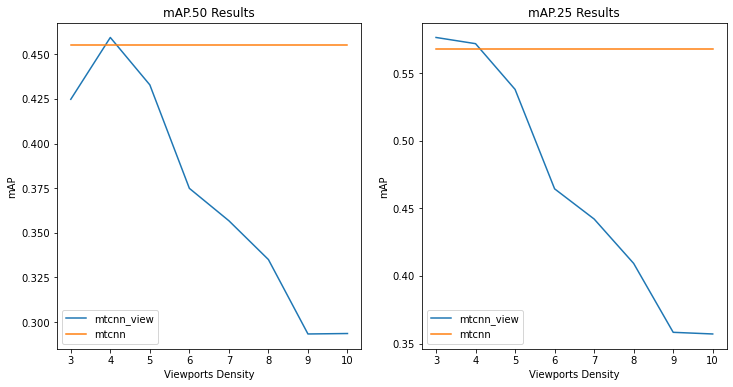

In [7]:
print(total_images_faces(dataset360))
d_numbers, mAPs_50, baseline_50 = evaluate_dataset(dataset360, threshold=0.50)
d_numbers, mAPs_25, baseline_25 = evaluate_dataset(dataset360, threshold=0.25)

plot_results(d_numbers, mAPs_50, baseline_50, mAPs_25, baseline_25)

## Close to Poles

In [12]:
poles = dataset360.loc[dataset360.phi.apply(abs) >= 80]
poles.shape

(322, 18)

Faces: 575 Images:322


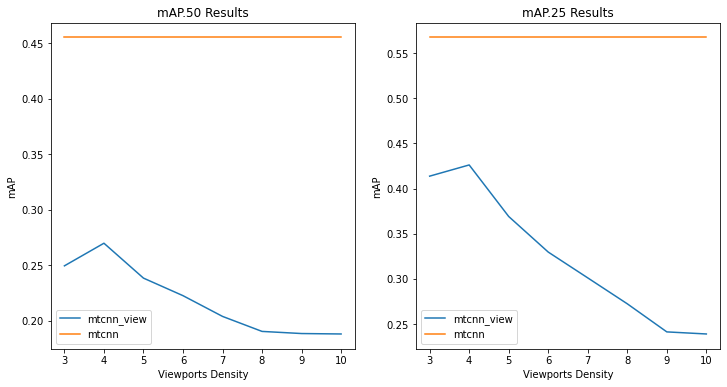

In [13]:
print(total_images_faces(poles))
d_numbers, mAPs_50, baseline_50 = evaluate_dataset(poles, threshold=0.50)
d_numbers, mAPs_25, baseline_25 = evaluate_dataset(poles, threshold=0.25)

plot_results(d_numbers, mAPs_50, baseline_50, mAPs_25, baseline_25)

## Close to Borders

In [10]:
borders = dataset360.loc[dataset360.theta.apply(abs) >= 165]
borders.shape

(239, 18)

Faces: 422 Images:239


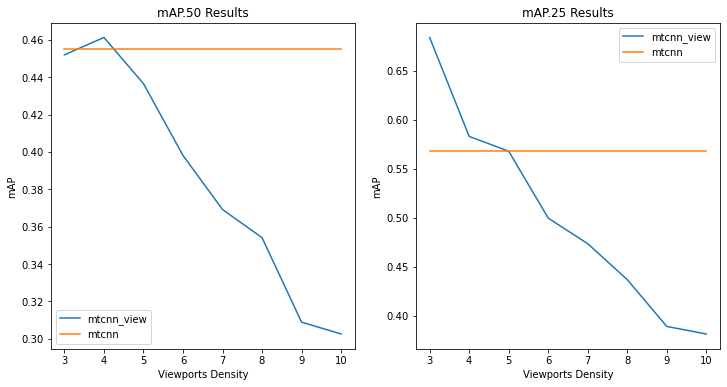

In [11]:
print(total_images_faces(borders))
d_numbers, mAPs_50, baseline_50 = evaluate_dataset(borders, threshold=0.50)
d_numbers, mAPs_25, baseline_25 = evaluate_dataset(borders, threshold=0.25)

plot_results(d_numbers, mAPs_50, baseline_50, mAPs_25, baseline_25)